In [1]:
# Import all required libraries``
import pandas as pd
from summarytools import dfSummary


# Set pandas options
pd.set_option('future.no_silent_downcasting', True)

### Exploratory Data Analysis

This part of my work mainly focuses on understanding the underlying data and various relationships between different attributes


In [2]:
df = pd.read_csv('data/train_file.csv')
df.sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
18531,31,services,married,basic.6y,no,yes,no,telephone,may,wed,492,2,0,nonexistent,no
1257,50,admin.,married,university.degree,no,no,no,cellular,jul,thu,356,1,0,nonexistent,yes
10473,29,services,single,high.school,no,no,no,telephone,may,thu,689,2,0,nonexistent,no
28544,36,services,single,basic.6y,unknown,yes,no,telephone,may,thu,164,2,0,nonexistent,no
2075,45,admin.,married,university.degree,no,no,no,cellular,sep,mon,394,1,0,nonexistent,no


In [3]:
dfSummary(data=df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,job[object],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,305 (25.2%)7,430 (22.6%)5,392 (16.4%)3,192 (9.7%)2,343 (7.1%)1,364 (4.1%)1,159 (3.5%)1,098 (3.3%)855 (2.6%)798 (2.4%)974 (3.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9RJREFUeJzt3TFuE0EAhtE1shA0jiJLOUwOwWE5RG4TobggiMZoWiog62+HzXtFhGhw8WmsXc0fDtfrdYHCh+RfAbFREhsZsZERGxmxkREbGbGRERuZw7Isn5dl+bjM6ef1en3d+kOwjuP5fP5yOp3ulwldLpdvh8Phq+D24ThCe3x8fL27u/uxTOTl5eXT09PT/fPz8zh1xbYDx/FjhPbw8PB9mc/4imcnPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvtFaNxd2yZzIyfibc5jtuw45LijHfHxmcbV8O3/hyswwaBzMGvzOK9nmxOsh2bal1lTbVv06yrrKn2b7Z11XRPxKzHS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzbe3+Blhs/AOxq8GLjsm2vhZAxe2N3J5sSiGbwYspAMXgxZqAcvmz/psj0vdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2NjP4MWQhXTwYsjC4Fo4GYMXMh4Q+G++Rn090qyrrKZI1lVWU9TrKqsp/pgHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNuZfV1lNka6rrKb4G66Fk7GuYtqTzUlGM3gxcCEZvBi4UA9eDFz4Z17qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd/gxcCFdPBi4MJbuBZOxuCFKU42pxjN4MW4hWTwYtxCPXgxbmFVXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvbrqssqUjXVZZUrM0GgYx1FZufbE41mnWVZRXJusqyinpdZVnF6rzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiY7vBi7EL6eDF2IVbcC2cjMELGScbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJDxgMCmX6O+QmnWVZZVJOsqyyrqdZVlFTfhAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI1t1lWWVaTrKssqbsW1cDLWVWScbGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kXAsnY/BCxn+UxnaDl8HohZsPXsZfGL1QDl4GoxdW56UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREb2wxefv8z3HTwMhi9cAuuhZMxeCHjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjaXyCzy9TuLOK9JUAAAAAElFTkSuQmCC"">",0(0.0%)
3,marital[object],1. married2. single3. divorced4. unknown,"19,929 (60.6%)9,245 (28.1%)3,671 (11.2%)65 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAeFJREFUeJzt28Ft20AURdEZQ3DijQRDgEpIelARKTZFqAj3IBjiIk68YTAdZJNHDP85C29JGBeiKMzr67o2SHiKXAXERlJvrb201p6jV2X4XNf1oxVyOJ/PP47H4+vWN1LNsizvvfeflYI7jNCu1+vH6XT6vfXNVPF4PL7ebrfX+/0+nih1Yht/RmiXy+XX1jdTzEsrxgsCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsZE99TGOvOQuyaPo//swDvGNs1UVj7xsaVmW93FatxXiWPh2Piud0h26KR8pXhCImfExWu7xsxfTrasqrpL2Yqp1VdVV0l7MuK7yE82kvCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2aqKd8s98lOpnwVJ3B7YYNAjCkf032y+bQhs66yeCKyrrJ4Ir2umuJNlm35UZcYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb86yrLJ6IrqssnvgXNgjEWFcR

###  **Attributes and their possible meanings**

<details>

| **Column**    | **Column's meaning (presumably !!!)** |
|---------------|------------------------|
| age           | Client's current age |
| job           | Job category to which client's profession falls into |
| marital       | Marital Status of a client |
| education     | Level of education that a contacted person has achieved so far |
| default       | Column indicating if this person had credit defaults in the past? |
| housing       | Column indicating whether a client posesses own real estate property? Alternatively, this could also indicate whether a contacted person has an active mortgage loan?|
| loan          | Column indicating whether an individual has any active/remaining loans?|
| contact       | Phone type used for communications ('cellular', 'telephone') |
| month         | Month when contact took place ('jan', 'feb',  ..., 'dec')|
| day_of_week   | Weekday when contact took place |
| duration      | Call duration? (probably in seconds) |
| campaign      | The number of contact attempts made during current campaign? |
| previous      | Number of contact attempts made during previous campgaign?|
| poutcome      | Outcome of the previous marketing campaign? ('success', 'failure', 'other', 'unknown') |
| y             | Target column, indicating whether a given person has agreed to make a deposit |

</details>

### **Issues and flaws present in the dataset**

<details>


An initial analysis reveals that this dataset contains the following flaws and inconsistencies that should be adressed:

1. All categorical attributes are stored as objects (i.e. text-data).

2. 8 rows are full duplicates of already existing rows.

3. Although at first glance, there seem to be no missing values, some columns
like ```marital```, ```education```, ```housing``` etc. contain value called *unknown*, which in its essense is equivalent to N/A since it does not provide us any useful meaning on its own. Neither can we regard it as category on its own. 
  

</details>
















#### Data Cleaning

In order to keep this Notebook neat and tidy, I have moved all cumbersome code and functions responsible for preprocessing data for this use-case to a separate Python file called "custom_functions.py". Feel free to inspect the source file if you are interested in details of my implementations and approaches. 

In [4]:
import custom_functions as cf

In [5]:
# Replace original values for certain columns
df = df.replace({'unknown': None})

# Impute N/A using relative frequency method instead of dropping them or using KNN imputation
df_imputed = cf.probabilistic_imputation(df)    # Explain why this approach was chosen

# Convert all string columns to categorical
df_imputed = cf.convert_to_categorical(df_imputed, columns='all')

# Drop fully duplicated rows (which we know exist)
df_imputed = df_imputed.drop_duplicates()

In [6]:
dfSummary(data=df_imputed, is_collapsible=True, show_graph=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,0(0.0%)
2,job[category],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,364 (25.4%)7,482 (22.7%)5,425 (16.5%)3,226 (9.8%)2,367 (7.2%)1,379 (4.2%)1,165 (3.5%)1,109 (3.4%)865 (2.6%)807 (2.5%)713 (2.2%)",0(0.0%)
3,marital[category],1. married2. single3. divorced,"19,955 (60.6%)9,269 (28.2%)3,678 (11.2%)",0(0.0%)
4,education[category],1. university.degree2. high.school3. basic.9y4. professional.course5. basic.4y6. basic.6y7. illiterate,"10,145 (30.8%)7,928 (24.1%)5,041 (15.3%)4,354 (13.2%)3,462 (10.5%)1,956 (5.9%)16 (0.0%)",0(0.0%)
5,default[category],1. no2. yes,"32,899 (100.0%)3 (0.0%)",0(0.0%)
6,housing[category],1. yes2. no,"17,659 (53.7%)15,243 (46.3%)",0(0.0%)
7,loan[category],1. no2. yes,"27,769 (84.4%)5,133 (15.6%)",0(0.0%)
8,contact[category],1. cellular2. telephone,"20,884 (63.5%)12,018 (36.5%)",0(0.0%)
9,month[category],1. may2. jul3. aug4. jun5. nov6. apr7. oct8. sep9. mar10. dec,"10,991 (33.4%)5,752 (17.5%)4,943 (15.0%)4,242 (12.9%)3,262 (9.9%)2,083 (6.3%)586 (1.8%)464 (1.4%)436 (1.3%)143 (0.4%)",0(0.0%)
10,day_of_week[category],1. thu2. mon3. wed4. tue5. fri,"6,846 (20.8%)6,801 (20.7%)6,508 (19.8%)6,436 (19.6%)6,311 (19.2%)",0(0.0%)


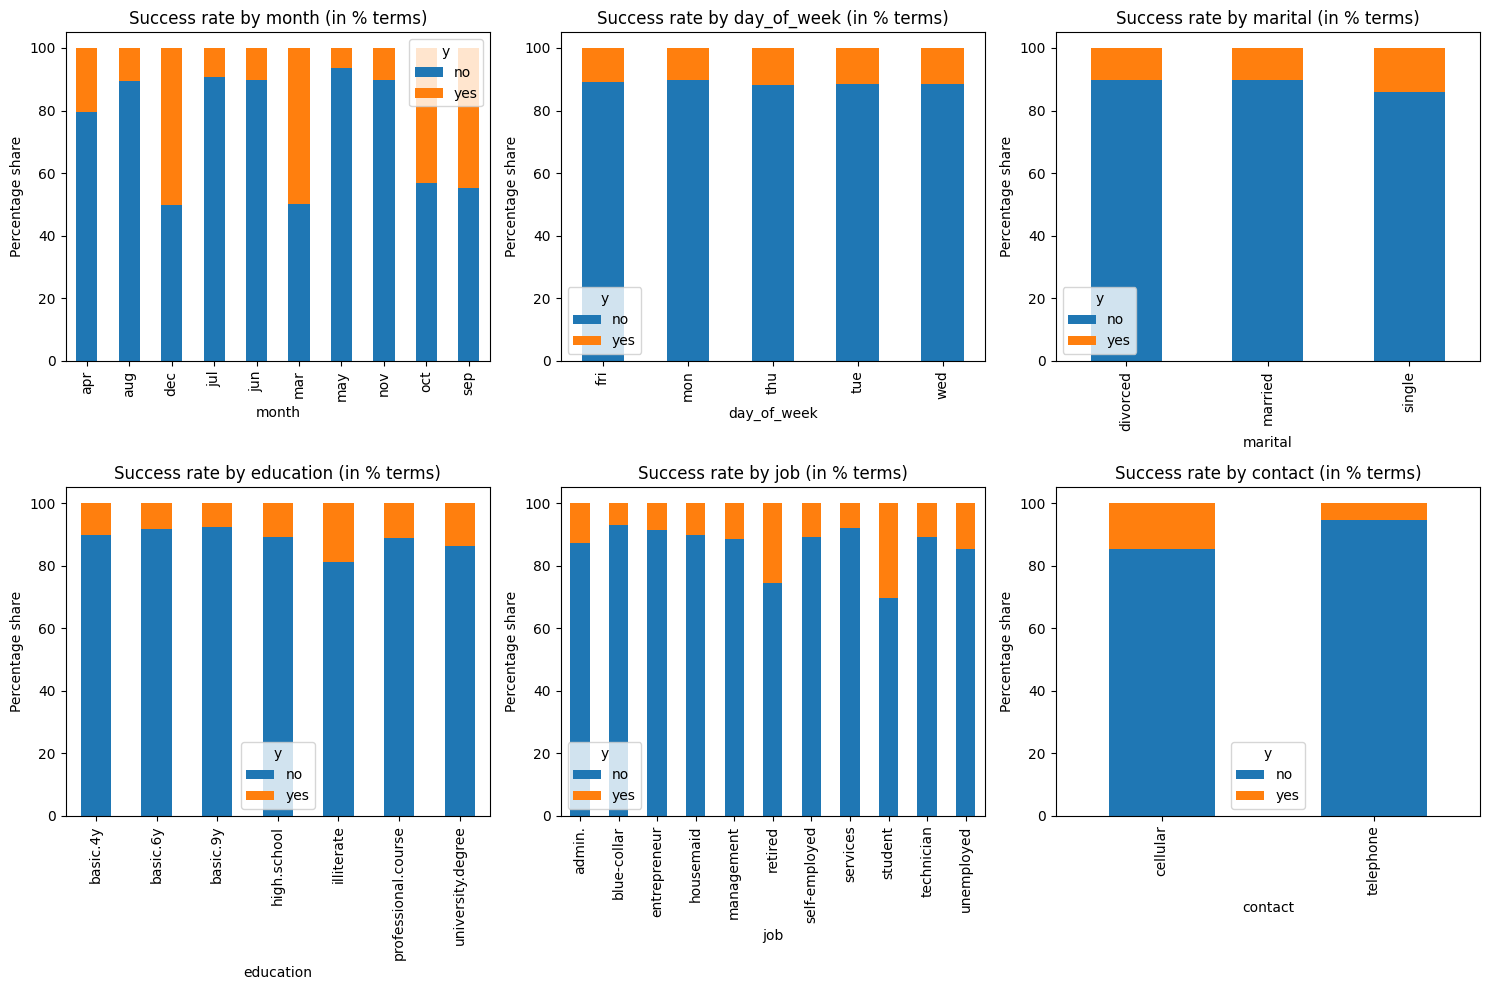

In [7]:
# Calculate the correlation between the target variable and categorical variables
cf.show_categorical_correlation(df, target='y', cols_to_consider=['month', 'day_of_week', 'marital', 'education', 'job', 'contact'], show_details=False)